In [3]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [4]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [5]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [6]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

Index(['load'], dtype='object')

In [7]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,29059.0
2015-01-01 01:00:00,28663.0
2015-01-01 02:00:00,26626.0
2015-01-01 03:00:00,24778.0
2015-01-01 04:00:00,23212.0
...,...
2015-12-31 19:00:00,35944.0
2015-12-31 20:00:00,33128.0
2015-12-31 21:00:00,30488.0


In [8]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [ ]:
# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "offshorewind")
network.add("Carrier", "nuclear")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex * (1+0.03) # in €/MW 
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_windOnshore.values)

# add offshore wind generator
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex *(1+0.03) # in €/MW 
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshore,
            marginal_cost = 0,
            p_max_pu = CF_windOffshore.values)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add CCGT (Combine Cycle Gas Turbine) generator
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)

# add nuclear generator
capital_cost_nuclear = annuity(30,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [10]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.601,0.606,0.0
2015-01-01 01:00:00,0.569,0.610,0.0
2015-01-01 02:00:00,0.538,0.592,0.0
2015-01-01 03:00:00,0.539,0.570,0.0
2015-01-01 04:00:00,0.561,0.552,0.0
...,...,...,...
2015-12-31 19:00:00,0.735,0.508,0.0
2015-12-31 20:00:00,0.666,0.426,0.0
2015-12-31 21:00:00,0.554,0.336,0.0


In [11]:
network.optimize(solver_name='gurobi', Outputflag = 0)

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 35.37it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-w5dfh5p7.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-w5dfh5p7.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96365 rows, 43805 columns, 170959 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170959 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [12]:
print(network.objective/1000000) #in 10^6 €

20772.93169833319


In [13]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    73.611927
dtype: float64


In [14]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     49966.804979
offshorewind        0.000000
solar               0.000000
CCGT            49928.659751
nuclear             0.000000
Name: p_nom_opt, dtype: float64

In [26]:
# Calculate CO2 emissions in the system

# Initialize total CO2 emissions
total_co2_emissions = 0

# Loop through all generators
for generator in network.generators.index:
    # Check if the generator's carrier emits CO2
    carrier = network.generators.loc[generator, "carrier"]
    if carrier in network.carriers.index and "co2_emissions" in network.carriers.columns:
        co2_emissions_factor = network.carriers.loc[carrier, "co2_emissions"]  # t_CO2/MWh_th
        generation = network.generators_t.p[generator].sum()  # Total generation in MWh
        total_co2_emissions += generation * co2_emissions_factor  # Add to total emissions

# Print total CO2 emissions
print(f"Total CO2 emissions: {total_co2_emissions:.2f} tons")

Total CO2 emissions: 34453413.99 tons


<h2>Plot a week in winter</h2>

C:\Users\carlo\AppData\Local\Temp\ipykernel_28944\2163339799.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')


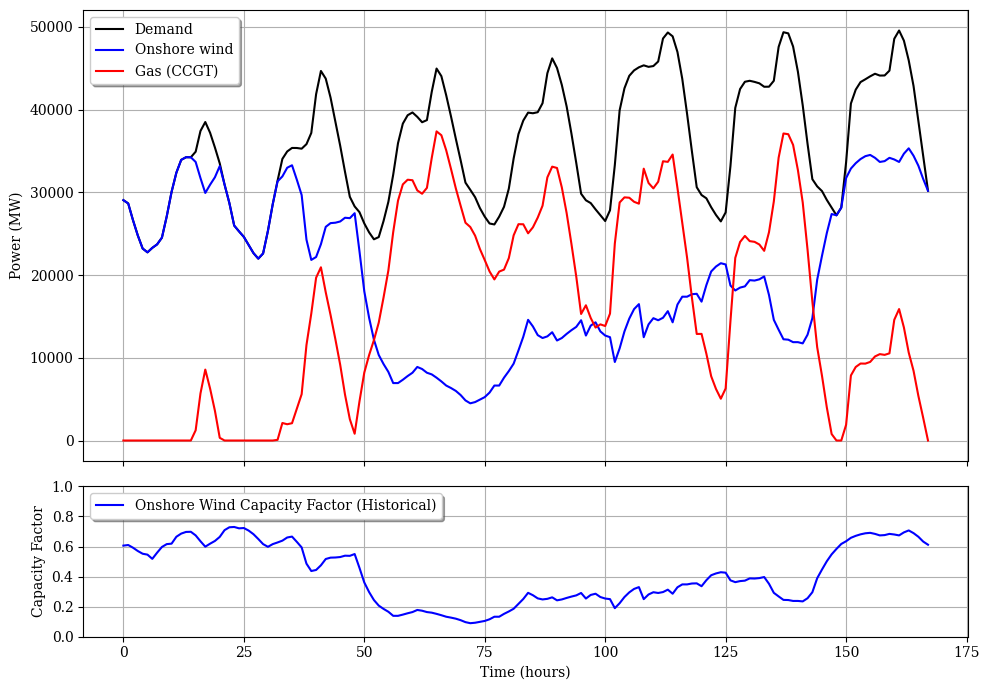

In [15]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

# Add the second plot in the same figure
fig, axs = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

# First plot: Energy production and demand
axs[0].plot(demand, color='black', label='Demand')
axs[0].plot(onshore_wind, color='blue', label='Onshore wind')
# axs[0].plot(solar, color='orange', label='Solar')
axs[0].plot(gas_ccgt, color='red', label='Gas (CCGT)')
# axs[0].plot(offshore_wind, color='green', label='Offshore wind')
# axs[0].plot(nuclear, color='brown', label='Nuclear')
axs[0].legend(fancybox=True, shadow=True, loc='upper left')
axs[0].set_ylabel('Power (MW)')
axs[0].grid(True)

# Remove x-axis labels and title for the first plot
axs[0].tick_params(labelbottom=False)
axs[0].set_title('')  # Remove title if any

# Second plot: Onshore wind capacity factor (adjusted to the same time period as above)
CF_windOnshore_week = CF_windOnshore[[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in hours]].values
axs[1].plot(CF_windOnshore_week, color='blue', label='Onshore Wind Capacity Factor (Historical)')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel('Capacity Factor')
axs[1].legend(fancybox=True, shadow=True, loc='upper left')
axs[1].grid(True)
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()

<h2>Plot a week in summer</h2>

C:\Users\carlo\AppData\Local\Temp\ipykernel_28944\975276197.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')


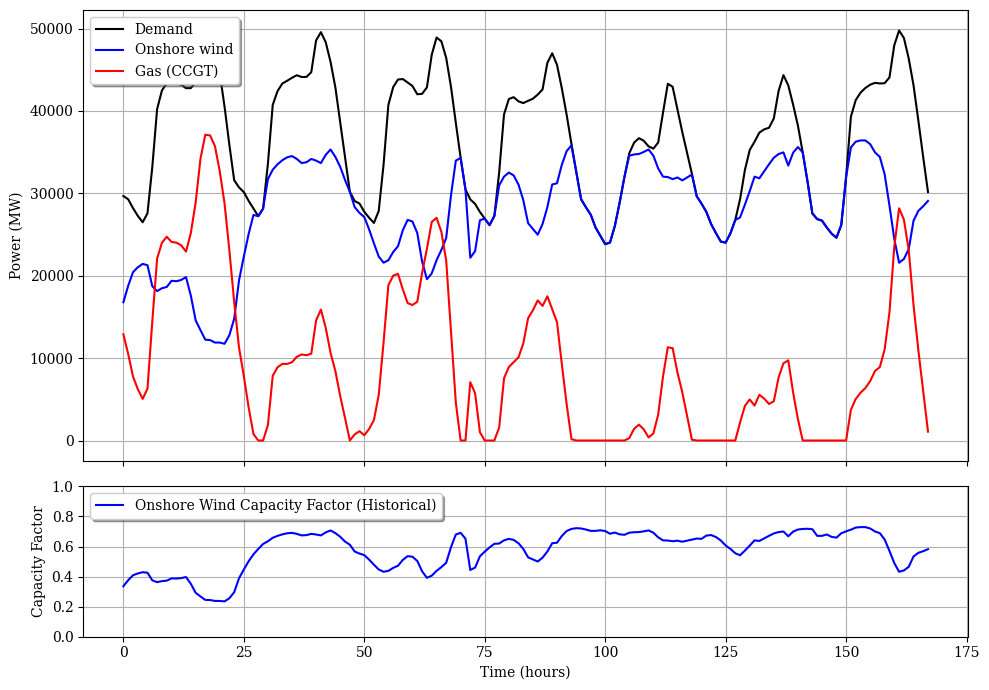

In [16]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

# Add the second plot in the same figure
fig, axs = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

# First plot: Energy production and demand
axs[0].plot(demand, color='black', label='Demand')
axs[0].plot(onshore_wind, color='blue', label='Onshore wind')
# axs[0].plot(solar, color='orange', label='Solar')
axs[0].plot(gas_ccgt, color='red', label='Gas (CCGT)')
# axs[0].plot(offshore_wind, color='green', label='Offshore wind')
# axs[0].plot(nuclear, color='brown', label='Nuclear')
axs[0].legend(fancybox=True, shadow=True, loc='upper left')
axs[0].set_ylabel('Power (MW)')
axs[0].grid(True)

# Remove x-axis labels and title for the first plot
axs[0].tick_params(labelbottom=False)
axs[0].set_title('')  # Remove title if any

# Second plot: Onshore wind capacity factor (adjusted to the same time period as above)
CF_windOnshore_week = CF_windOnshore[[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in hours]].values
axs[1].plot(CF_windOnshore_week, color='blue', label='Onshore Wind Capacity Factor (Historical)')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel('Capacity Factor')
axs[1].legend(fancybox=True, shadow=True, loc='upper left')
axs[1].grid(True)
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()

Text(0.5, 1.07, 'Electricity mix')

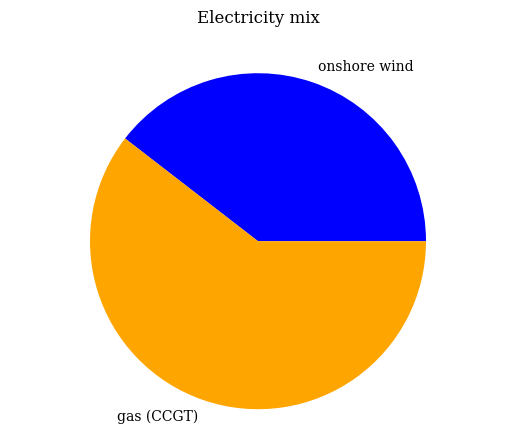

In [17]:
labels = ['onshore wind',
          'gas (CCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
]

colors=['blue', 'orange', 'brown', 'green', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

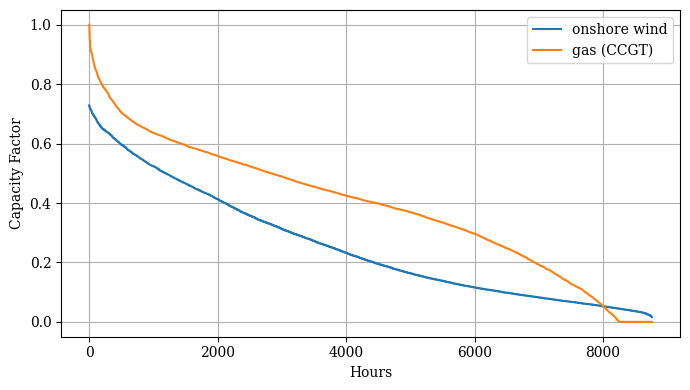

In [18]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

# plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Statistichs comparing offshore and onshore

In [25]:
# Hypothetical full-load hours and variance calculation for 1 MW installed capacity

# Total hours in a year
hours_per_year = 8760

# Full-load hours calculation based on capacity factor
full_load_hours_onshore = CF_windOnshore.sum() 
full_load_hours_offshore = CF_windOffshore.sum()

# Variance of capacity factors
variance_CF_onshore = CF_windOnshore.var()
variance_CF_offshore = CF_windOffshore.var()

# Print results
print("Hypothetical Full-Load Hours and Variance (1 MW Installed Capacity):")
print(f"Onshore Wind:")
print(f"  Full-load hours per year: {full_load_hours_onshore:.2f} hours")
print(f"  Variance of capacity factor: {variance_CF_onshore:.6f}")

print(f"\nOffshore Wind:")
print(f"  Full-load hours per year: {full_load_hours_offshore:.2f} hours")
print(f"  Variance of capacity factor: {variance_CF_offshore:.6f}")

Hypothetical Full-Load Hours and Variance (1 MW Installed Capacity):
Onshore Wind:
  Full-load hours per year: 2278.24 hours
  Variance of capacity factor: 0.036943

Offshore Wind:
  Full-load hours per year: 3048.83 hours
  Variance of capacity factor: 0.056191
